In [6]:
#libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import os, re

In [13]:
#import
files = {
    "Sex":         Path("results/corr_sex.csv"),
    "Income":      Path("results/corr_income.csv"),
    "Education":   Path("results/corr_education.csv"),
    "Race/Ethnicity": Path("results/corr_race.csv"),
}

In [25]:
#behavior headers in 
BEHAV_COLS = [
    "Low Veg Intake",
    "Low Fruit Intake",
    "150min Aerobic Activity",
    "150min Aerobic + Strength 2d",
    "300min Aerobic Activity",
    "Strength 2d",
    "No Leisure Activity",
]

#readd mathmatical symbols for plotting, they break on import..
SHORT = {
    "Low Veg Intake": "Low Veg Intake",
    "Low Fruit Intake": "Low Fruit Intake",
    "150min Aerobic Activity": "≥150m Aerobic Activity",
    "150min Aerobic + Strength 2d": "≥150min Aerobic + Strength ≥2d",
    "300min Aerobic Activity": "≥300m Aerobic Activity",
    "Strength 2d": "Strength ≥2d",
    "No Leisure Activity": "No Leisure Activity",
}

def load_corr_wide(path: Path, stratum_name: str) -> pd.DataFrame:
    df = pd.read_csv(path)
    #coerce to nums in case.. keeps breaking.
    for c in BEHAV_COLS:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")
        else:
            raise ValueError(f"{path.name} missing expected behavior column: {c}")

    #row labels
    non_num = [c for c in df.columns if c not in BEHAV_COLS and not pd.api.types.is_numeric_dtype(df[c])]
    if non_num:
        uniq_counts = {c: df[c].nunique(dropna=True) for c in non_num}
        row_label_col = max(uniq_counts, key=uniq_counts.get)
    else:
        row_label_col = None
        df["__row__"] = "All"
        row_label_col = "__row__"

    #melt wide to long
    long = df.melt(
        id_vars=[row_label_col],
        value_vars=BEHAV_COLS,
        var_name="behavior",
        value_name="corr",
    )

    #rempap labels
    long["demo"] = stratum_name + "=" + long[row_label_col].astype(str).str.strip()
    long["behavior"] = long["behavior"].map(SHORT).fillna(long["behavior"])
    return long[["demo", "behavior", "corr"]]

#load all
parts = []
for s, p in files.items():
    parts.append(load_corr_wide(p, s))
corr_all = pd.concat(parts, ignore_index=True)

#select top 5
corr_all["abs_corr"] = corr_all["corr"].abs()
top5 = (corr_all.sort_values(["demo","abs_corr"], ascending=[True, False])
                .groupby("demo", group_keys=False)
                .head(5))



In [26]:
corr_all["abs_corr"] = corr_all["corr"].abs()
top5 = (corr_all.sort_values(["demo","abs_corr"], ascending=[True, False])
                .groupby("demo", group_keys=False)
                .head(5)
                .copy())

#filename cleaner
def slug(s): 
    return re.sub(r"[^a-z0-9]+","-", s.lower()).strip("-")

#plot func
def plot_top5_for_demo(df_demo, outdir="fig_top5", show=True):
    os.makedirs(outdir, exist_ok=True)
    demo = df_demo["demo"].iloc[0]

    #order bars
    d = (df_demo.sort_values("abs_corr", ascending=True)
                .assign(behavior_wrapped=lambda x: x["behavior"].str.wrap(28)))
    xmax = max(0.2, d["abs_corr"].max())

    sns.set_theme(style="whitegrid")
    plt.figure(figsize=(7, 3 + 0.45*len(d)))
    ax = sns.barplot(
        data=d, x="corr", y="behavior_wrapped",
        orient="h", color="#5B8FF9", edgecolor="none"
    )

    #labels
    for p in ax.patches:
        x = p.get_width()
        y = p.get_y() + p.get_height()/2
        ax.text(x + 0.02*np.sign(x), y, f"{x:.2f}",
                va="center", ha="left" if x>=0 else "right", fontsize=9)

    ax.set_xlim(-1, 1)  #symmetric for fair comparison
    ax.set_xlabel("Correlation (r)")
    ax.set_ylabel("Behavior")
    ax.set_title(f"Top 5 Behavioral Correlates: {demo}", pad=10)
    ax.grid(axis="x", alpha=0.25)
    plt.tight_layout()

    path = os.path.join(outdir, f"top5_{slug(demo)}.png")
    plt.savefig(path, dpi=300, bbox_inches="tight")
    if show:
        plt.show()
    plt.close()
    return path


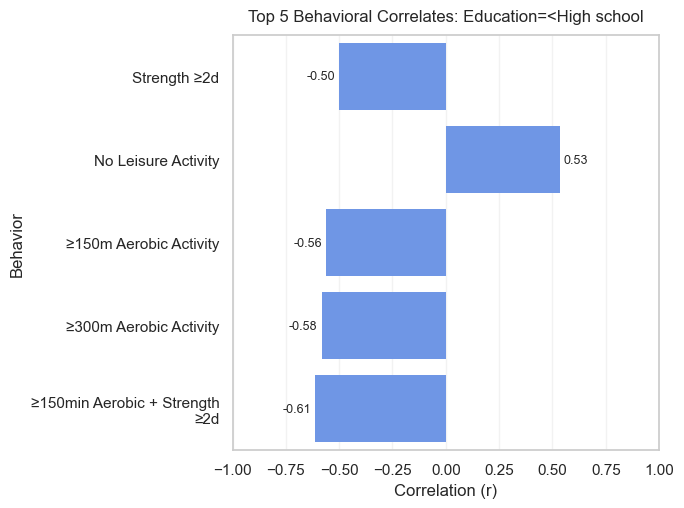

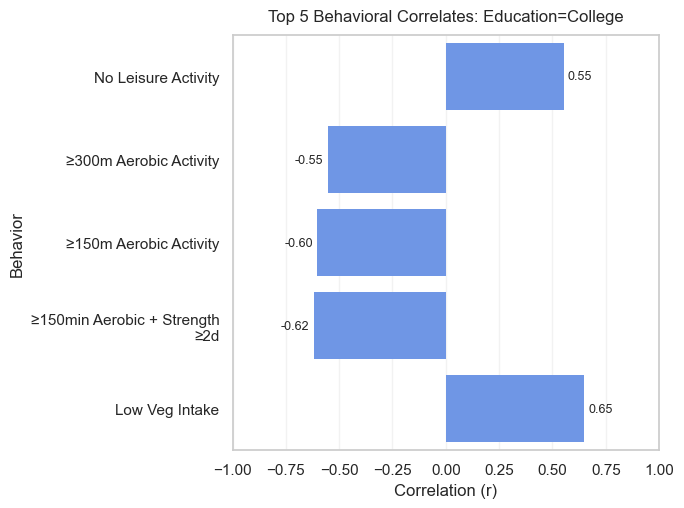

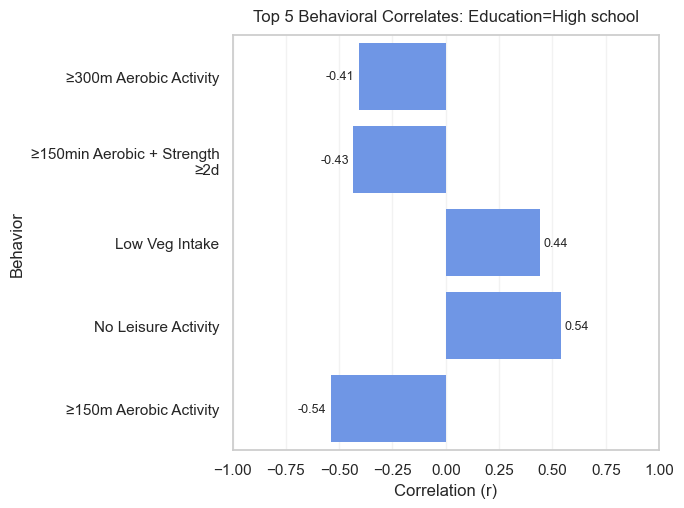

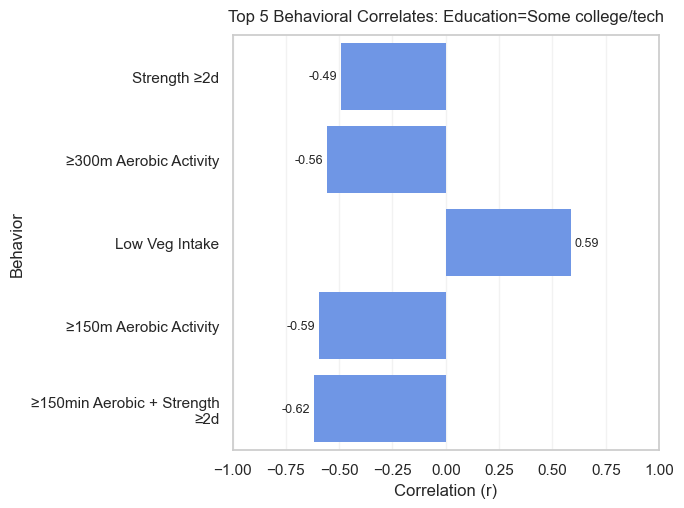

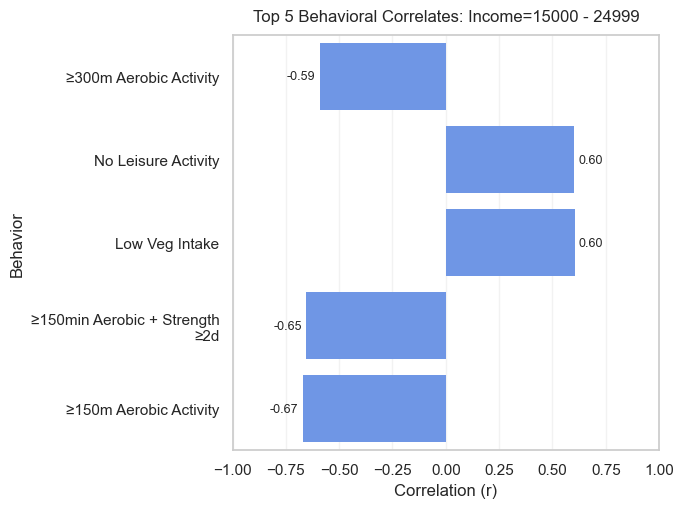

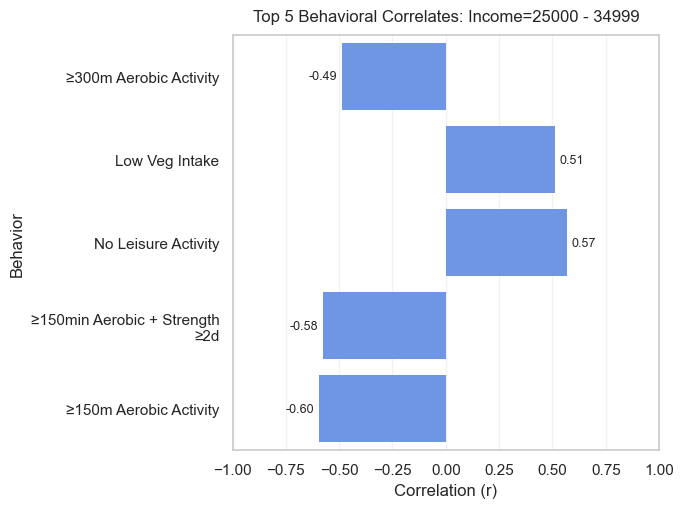

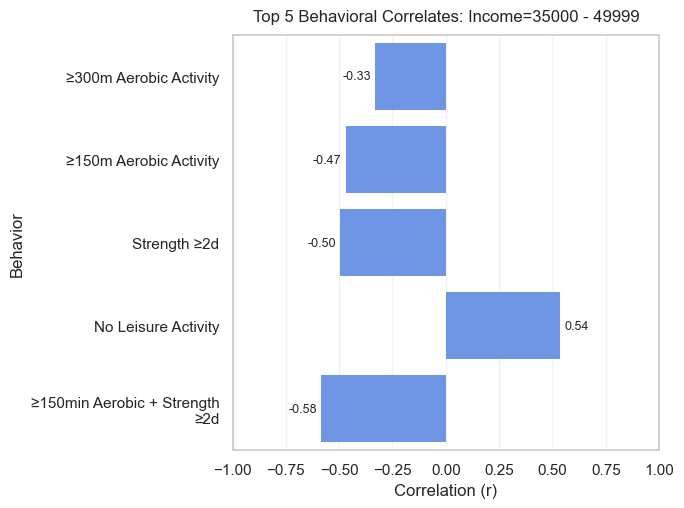

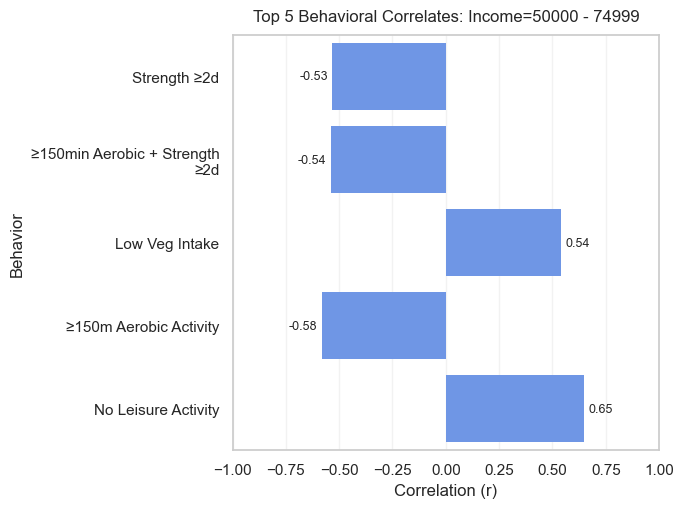

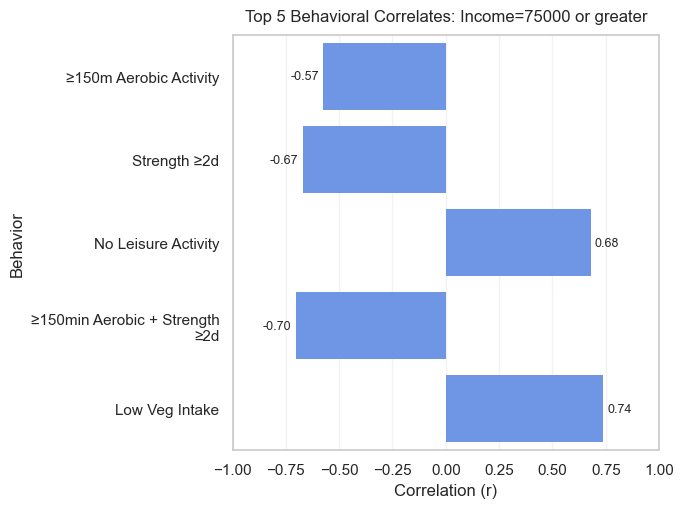

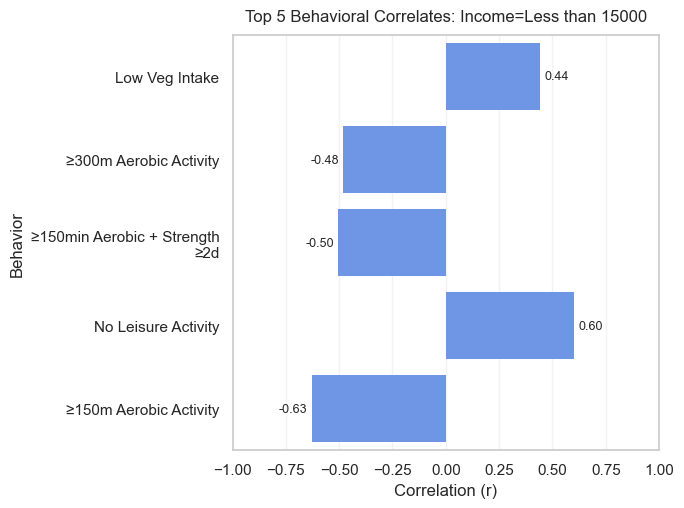

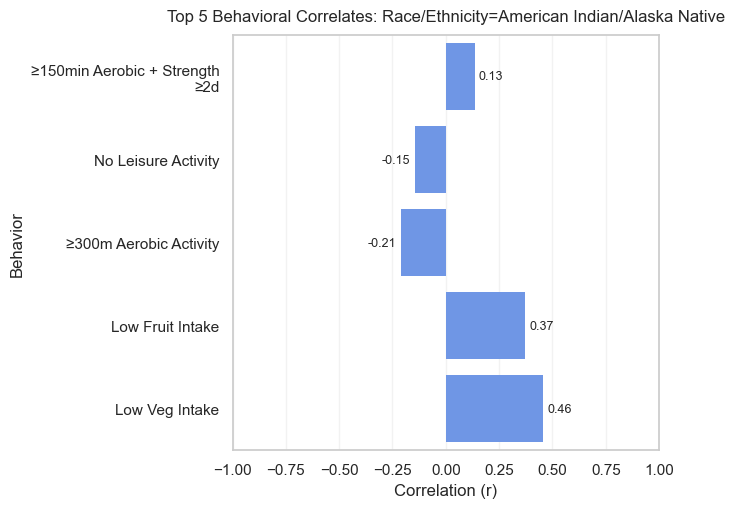

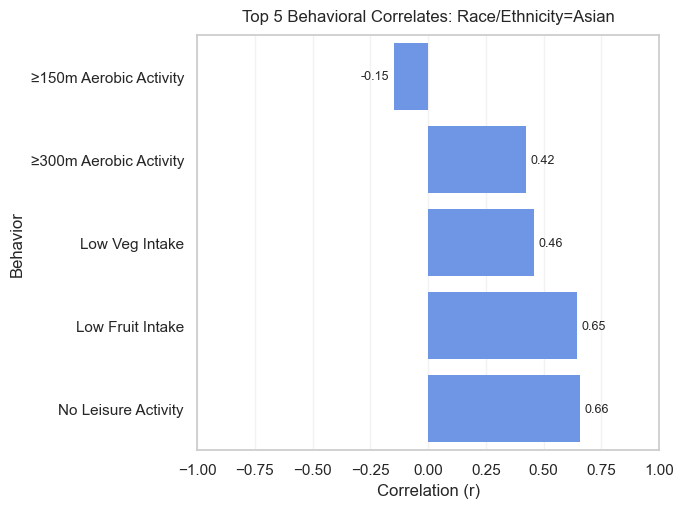

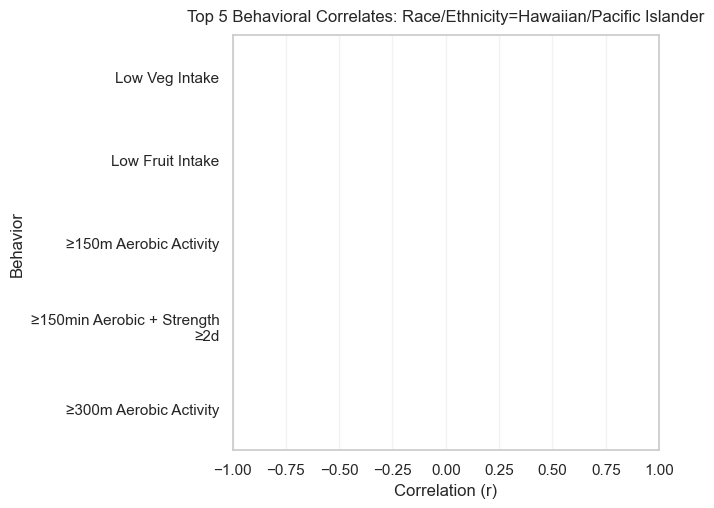

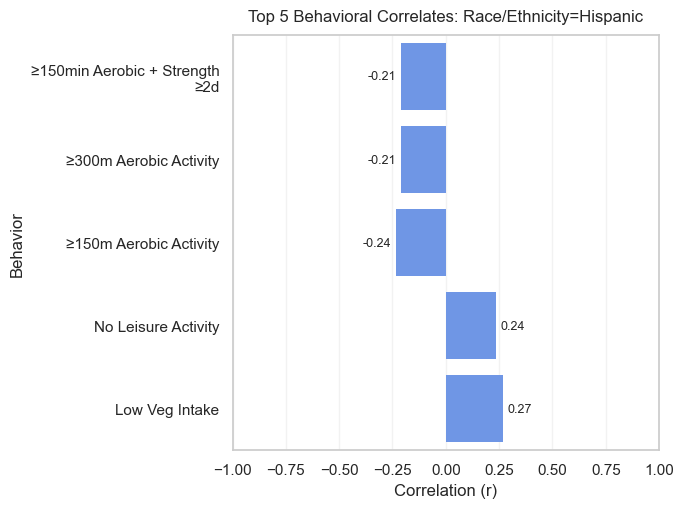

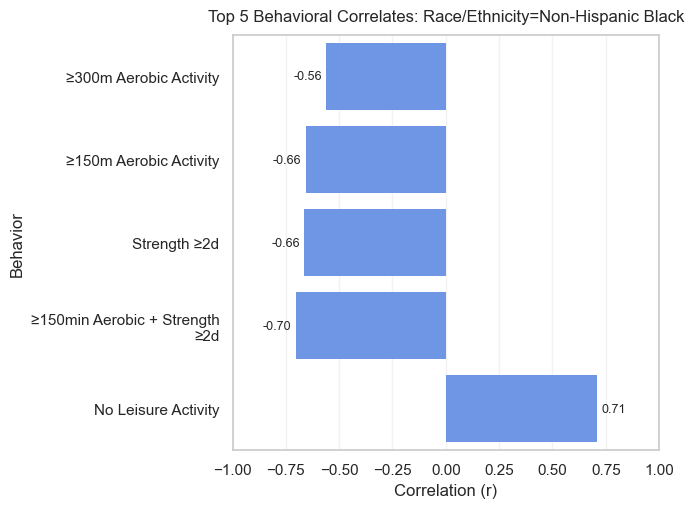

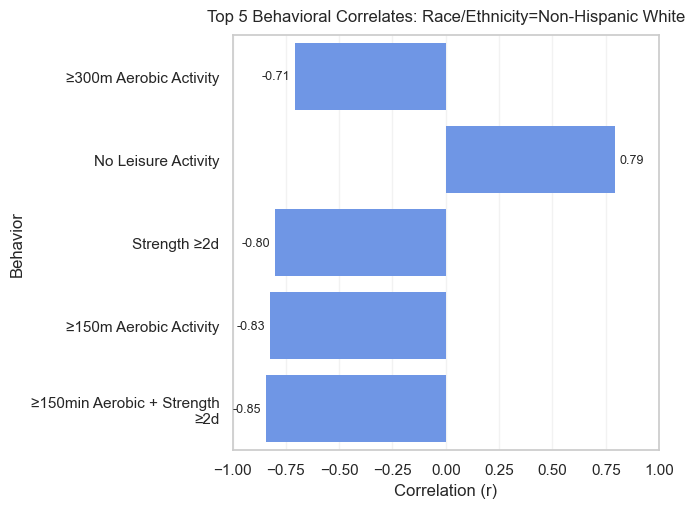

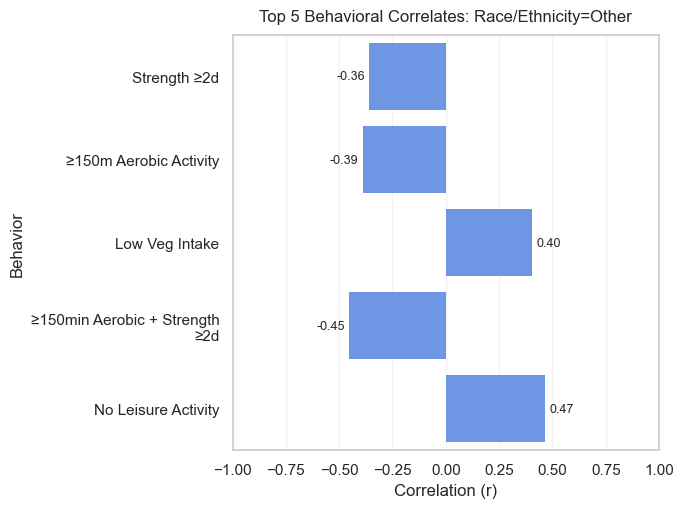

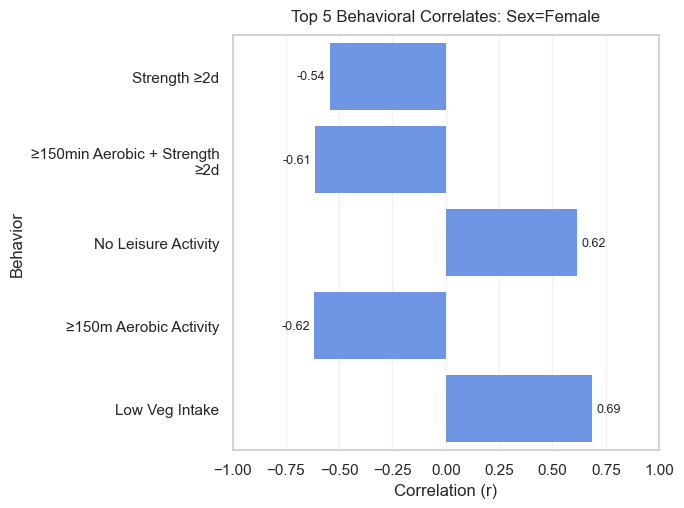

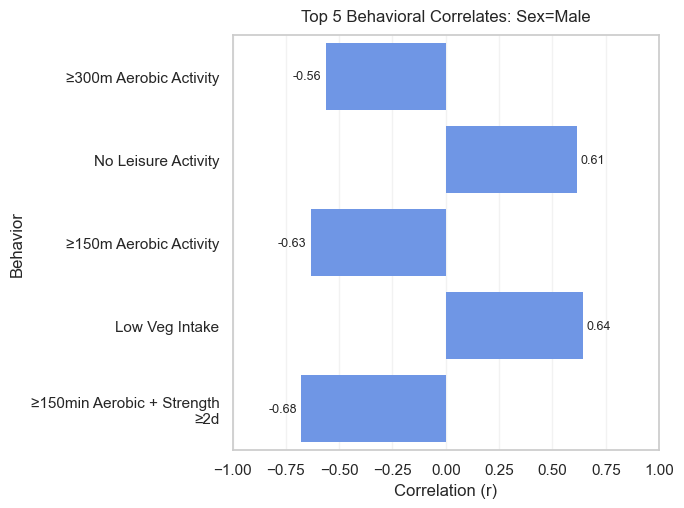

Saved:
- fig_top5\top5_education-high-school.png
- fig_top5\top5_education-college.png
- fig_top5\top5_education-high-school.png
- fig_top5\top5_education-some-college-tech.png
- fig_top5\top5_income-15000-24999.png
- fig_top5\top5_income-25000-34999.png
- fig_top5\top5_income-35000-49999.png
- fig_top5\top5_income-50000-74999.png
- fig_top5\top5_income-75000-or-greater.png
- fig_top5\top5_income-less-than-15000.png
- fig_top5\top5_race-ethnicity-american-indian-alaska-native.png
- fig_top5\top5_race-ethnicity-asian.png
- fig_top5\top5_race-ethnicity-hawaiian-pacific-islander.png
- fig_top5\top5_race-ethnicity-hispanic.png
- fig_top5\top5_race-ethnicity-non-hispanic-black.png
- fig_top5\top5_race-ethnicity-non-hispanic-white.png
- fig_top5\top5_race-ethnicity-other.png
- fig_top5\top5_sex-female.png
- fig_top5\top5_sex-male.png


In [27]:

#outputs
outputs = []
for demo, d in top5.groupby("demo", sort=True):
    outputs.append(plot_top5_for_demo(d, outdir="fig_top5", show=True))

print("Saved:", *outputs, sep="\n- ")